# Introduction  
To improve classification accuracy of the model on the test dataset, the following are explored:
* Input image size
* Pretrained model and number of trainable parameters of final model
* Data augmentation
* Regularization techniques
* Use of learning rate schedule


# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed on Kaggle
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import os
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import regularizers      # mitigate overfitting 
from kaggle_datasets  import KaggleDatasets    # import kaggle data files
# Stop training when a monitored metric has stopped improving
from tensorflow.keras.callbacks import EarlyStopping   
print("Tensorflow version " + tf.__version__)  # verify tensorflow versionis 2.x

2022-11-22 01:07:20.443616: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-22 01:07:20.443851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


# Detect Hardware

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. 
    # On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-11-22 01:07:26.646506: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-22 01:07:26.649927: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-22 01:07:26.649974: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 01:07:26.650003: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (53b3d47b45c4): /proc/driver/nvidia/version does not exist
2022-11-22 01:07:26.653770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


# Data Directories

In [3]:
# Input data files are available in the read-only "kaggle/input/" directory
#   image files are in TFRecords format, each of which contains a sequeence
#   of records and can only be read sequentially.

TFRec_selected = '512x512'
for dirpath, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if TFRec_selected in dirpath: # 
            print(os.path.join(dirpath, filename))

/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/02-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/12-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/09-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/00-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/13-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/03-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/14-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/04-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/10-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/05-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/08-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/11-512x512-232.tfrec
/kaggle/input/tp

In [4]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved 
# as output when you create a version using "Save & Run All" 
for dirpath, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirpath, filename))     
        
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of 
# the current session
!gsutil cp /kaggle/input/tpu-getting-started/sample_submission.csv /kaggle/temp/temp1.csv
for dirpath, _, filenames in os.walk('/kaggle/temp'):
    for filename in filenames:
        print(os.path.join(dirpath, filename))     
        

/kaggle/working/__notebook_source__.ipynb
Copying file:///kaggle/input/tpu-getting-started/sample_submission.csv...
/ [1 files][ 86.5 KiB/ 86.5 KiB]                                                
Operation completed over 1 objects/86.5 KiB.                                     
/kaggle/temp/temp1.csv


# Set up data path

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() 
# you can list the bucket with "!gsutil ls $GCS_DS_PATH"
print(GCS_DS_PATH)
!gsutil ls $GCS_DS_PATH

gs://kds-73fb71b40feae27a47dc494176d2bf59df6f7bec20f2bcdcb85d64b4
gs://kds-73fb71b40feae27a47dc494176d2bf59df6f7bec20f2bcdcb85d64b4/sample_submission.csv
gs://kds-73fb71b40feae27a47dc494176d2bf59df6f7bec20f2bcdcb85d64b4/tfrecords-jpeg-192x192/
gs://kds-73fb71b40feae27a47dc494176d2bf59df6f7bec20f2bcdcb85d64b4/tfrecords-jpeg-224x224/
gs://kds-73fb71b40feae27a47dc494176d2bf59df6f7bec20f2bcdcb85d64b4/tfrecords-jpeg-331x331/
gs://kds-73fb71b40feae27a47dc494176d2bf59df6f7bec20f2bcdcb85d64b4/tfrecords-jpeg-512x512/


# Set up parameters

In [6]:
# parameters set for tfrecords-jpeg-512x512 TFRecord files
IMAGE_SIZE        = [512, 512] 
HEIGHT            = IMAGE_SIZE[0]
WIDTH             = IMAGE_SIZE[1]
EPOCHS            = 20
BATCH_SIZE        = 16 * strategy.num_replicas_in_sync
NUM_TRAIN_IMAGES  = 12753
NUM_VAL_IMAGES    = 3712
NUM_TEST_IMAGES   = 7382
STEPS_PER_EPOCH   = NUM_TRAIN_IMAGES // BATCH_SIZE
AUTO              = tf.data.experimental.AUTOTUNE
TRAIN_FILENAMES   = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/train/*.tfrec') 
VAL_FILENAMES     = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/val/*.tfrec') 
TEST_FILENAMES    = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/test/*.tfrec') 

2022-11-22 01:07:41.736942: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-11-22 01:07:41.823313: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-11-22 01:07:41.895614: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Functions to handle data

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),    # shape [] means single element
        # class is missing, to be predicted flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of (image, idnum) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    
    # intercala automaticamente as leituras de vários arquivos
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    
    # usa nova ordenação ignorando a original
    dataset = dataset.with_options(ignore_order) 
    
    # retorna o dataset para (image, label) se rotulado=True or (image, id) pares se rotulado = false
    dataset = dataset.map(read_labeled_tfrecord if labeled 
                          else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_validation_dataset(filenames):
    dataset = load_dataset(filenames,labeled=True, ordered=False)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=2048)
    dataset = dataset.batch(BATCH_SIZE)
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_test_dataset(filenames, ordered=False):  # order matters to submit predictions to Kaggle
    dataset = load_dataset(filenames, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO) 
    return dataset

# Functions to get training dataset with data augmentation option
Isso significa gerar novos dados de treino a partir de dados ja existentes

In [8]:
# image augmentation                                  
def data_augment(image, label):
    # preenche a imagem com uma borda preta de 3 px
    # image = tf.image.resize_with_crop_or_pad(image, HEIGHT + 6, WIDTH + 6)
    # Randomly crop to original size from the padded image
    # image = tf.image.random_crop(image, size=[*IMAGE_SIZE,3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1) 
    image = tf.image.random_saturation(image, 0.7, 1.3)
    return image, label 

# aqui ele pega os dados com as opções de aumento de dados
def get_training_dataset(filenames, augmentation=False):
    # Thanks to the dataset.prefetch(AUTO) statement below, data pipeline code 
    #  is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    dataset = load_dataset(filenames, labeled=True, ordered=False)
    if augmentation:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(buffer_size=2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)  # prefetch next batch while training
    return dataset

# Visualização de dados em batches

In [9]:
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def show_images(databatch, row=6, col=8):
    #row = 6; col = 8;
    FIGSIZE = col*2
    plt.figure(figsize=(FIGSIZE,FIGSIZE/col*row))
    images, num_labl = batch_to_numpy_images_and_labels(databatch)
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.title(num_labl[j])
        plt.imshow(images[j,])
    plt.show()

# Explore image augmentation

Training Dataset
Sample Images: Original versus w/ Random Augmentation


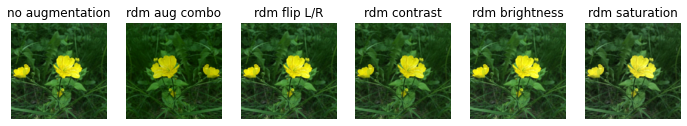

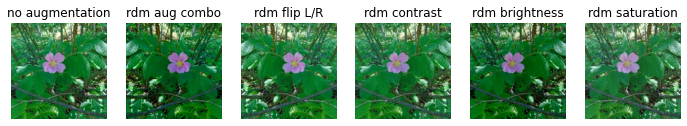

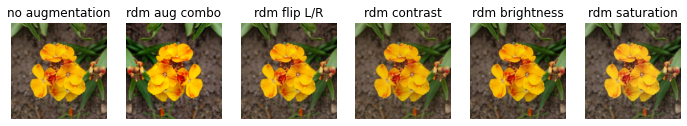

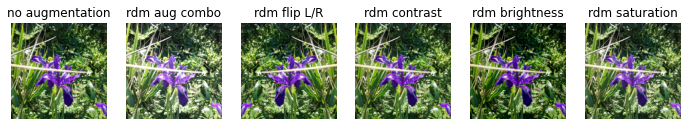

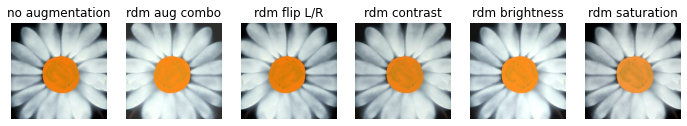

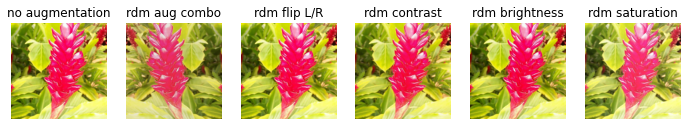

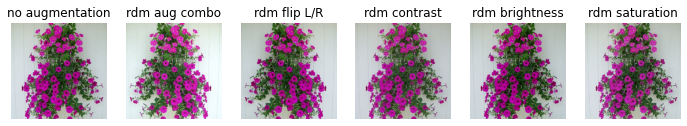

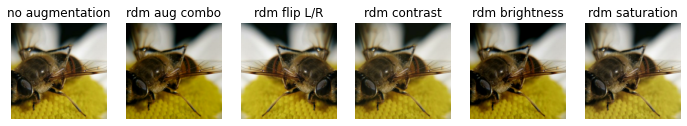

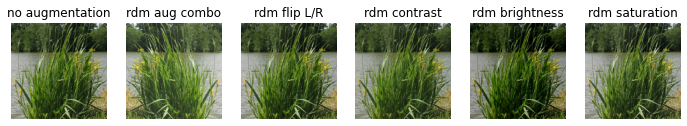

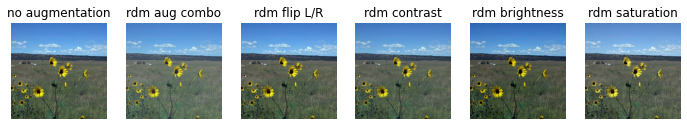

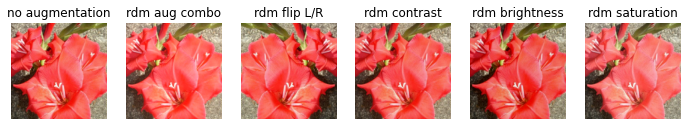

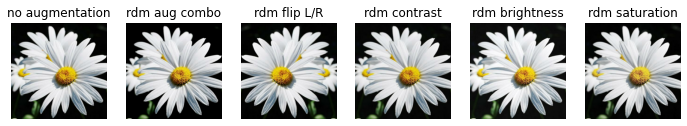

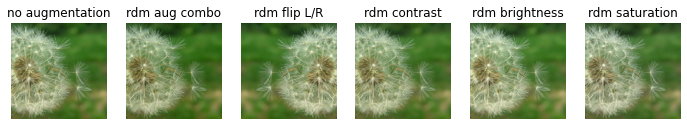

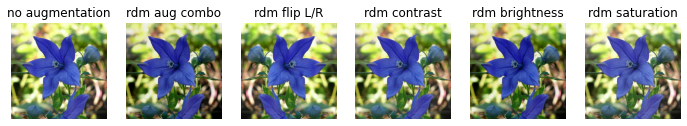

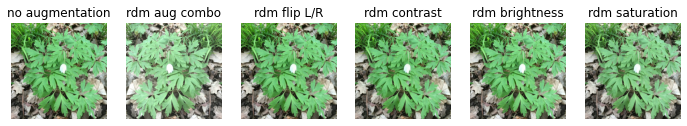

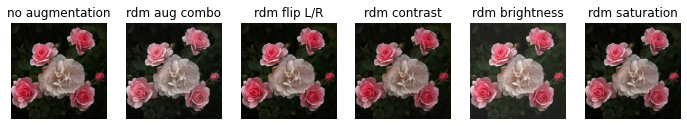

In [10]:
# Pega novamente o conjunto original de imagens sem o "aumento"
ori_train_set = get_training_dataset(TRAIN_FILENAMES, augmentation=False)
ori_image_batch = (next(iter(ori_train_set.unbatch().batch(16)))) # get a batch for 
images, _ = batch_to_numpy_images_and_labels(ori_image_batch)

# mostra imagens com "aumento" randomico
def show_aug(image):
    plt.figure(figsize=(12,2))
    plt.subplot(1,6,1)
    plt.imshow(image)
    plt.title('no augmentation')
    plt.axis('off')
    plt.subplot(1,6,3)
    plt.imshow(tf.image.random_flip_left_right(image))       # augmented with random flip
    plt.title('rdm flip L/R')
    plt.axis('off')    
    plt.subplot(1,6,4)
    plt.imshow(tf.image.random_contrast(image, 0.90, 0.99))  # augmented with contrast
    plt.title('rdm contrast')
    plt.axis('off')
    plt.subplot(1,6,5)
    plt.imshow(tf.image.random_brightness(image, 0.1))       # augmented with brightness
    plt.title('rdm brightness')
    plt.axis('off')
    plt.subplot(1,6,6)
    plt.imshow(tf.image.random_saturation(image, 0.8, 0.9))  # augmented with saturation
    plt.title('rdm saturation')
    plt.axis('off')
    plt.subplot(1,6,2)
    image = data_augment(image, None)
    plt.imshow(image[0])  # any random combinations of the above augmenations, if any
    plt.title('rdm aug combo')
    plt.axis('off')    
    plt.show()

# show images
print('Training Dataset')
print('Sample Images: Original versus w/ Random Augmentation')
for im in images:
    show_aug(im)

# Select train, val and test datasets 

In [11]:
# Pega o dataset treinado sem o "aumento"
training_dataset   = get_training_dataset(TRAIN_FILENAMES, augmentation=True)
validation_dataset = get_validation_dataset(VAL_FILENAMES)
# ordena para submissao
test_dataset       = get_test_dataset(TEST_FILENAMES, ordered=True)

print('trainin dataset:    ', training_dataset)
print('validation dataset: ', validation_dataset)
print('test dataset:       ', test_dataset)

trainin dataset:     <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
validation dataset:  <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
test dataset:        <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>


# Visualize image samples

Training Images with random data augmentation in data pipeline


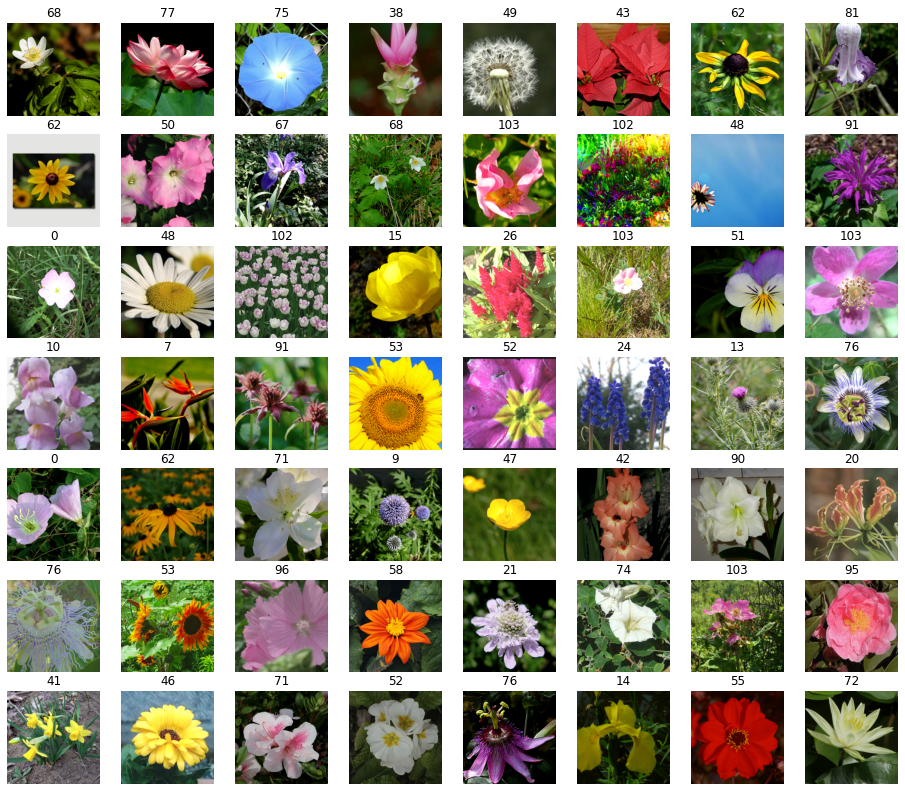

Validation Images


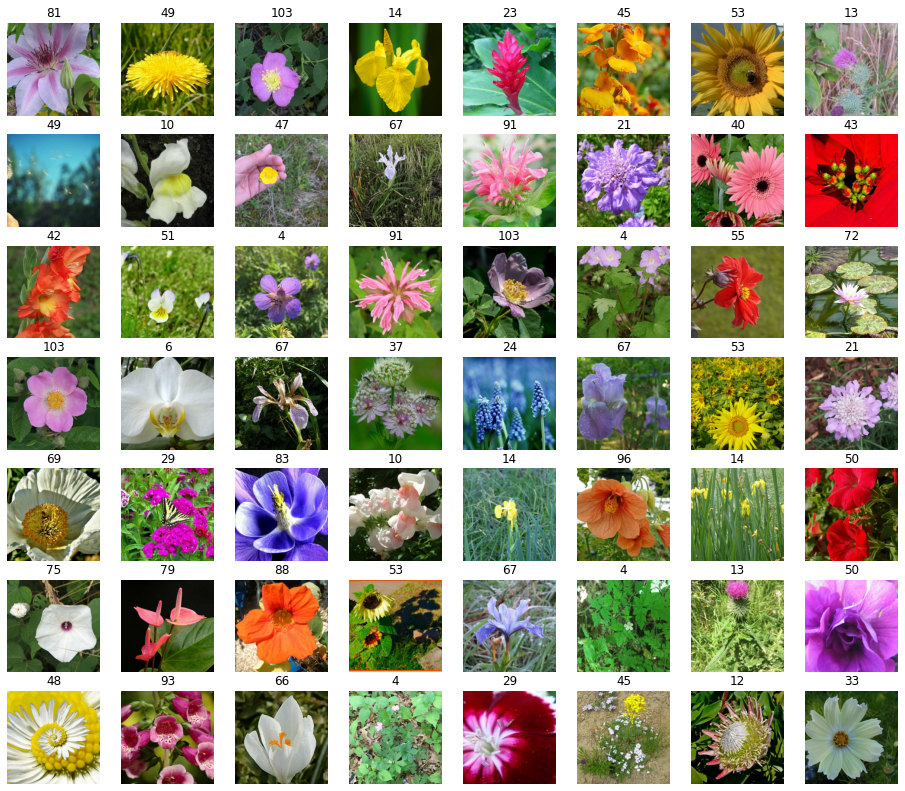

In [ ]:
# executar essas linhas repetidamente para obter amostras diferentes dos conjuntos de imagens
print('Training Images with random data augmentation in data pipeline')
show_images(next(iter(training_dataset.unbatch().batch(56))), row=7, col=8)
print('Validation Images')
show_images(next(iter(validation_dataset.unbatch().batch(56))), row=7, col=8)
print('Test Images - shuffled')
show_images(next(iter(test_dataset.shuffle(buffer_size=80).unbatch().batch(56))), row=7, col=8)

> # Construindo o modelo

In [ ]:
'''
Pré processamento de imagens

data_augmentation = tf.keras.Sequential([
   tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = SEED),
   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2, seed = SEED)
])
'''

# With pretrained model: InceptionV3
with strategy.scope():    
    pretrained_model = tf.keras.applications.DenseNet201(
        weights='imagenet', 
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = True # transfer learning
    model = tf.keras.Sequential([ # # define que o modelo é composto de camadas sequências
        pretrained_model,
        tf.keras.layers.Dropout(0.2),  # subiu
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(104, #tamanho
            kernel_regularizer=regularizers.l2(0.00011), 
            activation='softmax') #
    ]) #104 neurônios (classes possíveis de saída), ativação Softmax (define a % de certeza)
#finalmente compila o modelo
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
# display pretrained DenseNet201 base model summary
print('############ pretrained DenseNet201 base model summary ############')
pretrained_model.summary()

In [ ]:
# display model summary
print('######################### MODELO ########################')
model.summary()

# Monitor model metrics and EarlyStopping

In [ ]:
# Learning Rate Schedule for Fine Tuning 
def exponential_lr(epoch,
                  start_lr=0.00001,min_lr=0.00001,max_lr=0.00005,
                  rampup_epochs = 5, sustain_epochs = 0,
                  exp_decay = 0.8):
    def lr(epoch, start_lr, min_lr,max_lr,rampup_epochs,sustain_epochs,
          exp_decay):
        # Aumento linear
        if epoch < rampup_epochs:
            lr= ((max_lr-start_lr)/
                rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr 
        else:
            lr = ((max_lr - min_lr)* exp_decay ** (epoch-rampup_epochs-sustain_epochs)
                  + min_lr)
            
        return lr
    return lr(epoch,start_lr,min_lr,max_lr,rampup_epochs,sustain_epochs,exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr,verbose=True)

# gráfico de taxa de aprendizado
epoch_rng = [i for i in range(EPOCHS+31)]
y = [exponential_lr(x) for x in epoch_rng]
plt.plot(epoch_rng,y)
plt.xlim(-1, EPOCHS+32)

print("Learning rate schedule: start = {:.3g}; peak = {:.3g}; end = {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# Stop training when a monitored metric has stopped improving
earlystopping = EarlyStopping(monitor='val_loss', patience=2)

# Train the model

In [ ]:
# fit the model
historical = model.fit(
    training_dataset, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=EPOCHS, 
    validation_data=validation_dataset,
    # continuously monitoring val_loss
    # adjust learning rate & determine earlystopping
    callbacks=[lr_callback,earlystopping]  
)

# Plots: métricas de acurácia e perda

In [ ]:
# Criando plots de acurácia e perda de datasets de traino e validacao

acc = historical.history['sparse_categorical_accuracy']
val_acc = historical.history['val_sparse_categorical_accuracy']

loss = historical.history['loss']
val_loss = historical.history['val_loss']

epochs_range = range(1, len(historical.history['loss'])+1)

plt.figure(figsize=(14, 14))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Acurácia de treino')
plt.plot(epochs_range, val_acc, label='Acurácia de validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treino e de validação')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Perda (treino)')
plt.plot(epochs_range, val_loss, label='Perda (validação)')
plt.legend(loc='upper right')
plt.title('Perda de treino e de validação')
plt.xlabel('Epoch')
plt.show()

# cálculo de previsões no conjunto de teste

In [ ]:
print('Predictions...')
test_images_ds = test_dataset.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Gerando submission.csv file...')
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), 
           fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')